# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works and how the solution converges. This is also the first synthetic that will be shown in the paper.

In [1]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create a model and data

Make a model from a dipole. Add some gaussian random noise.

Number of data: 5712


/home/leo/bin/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


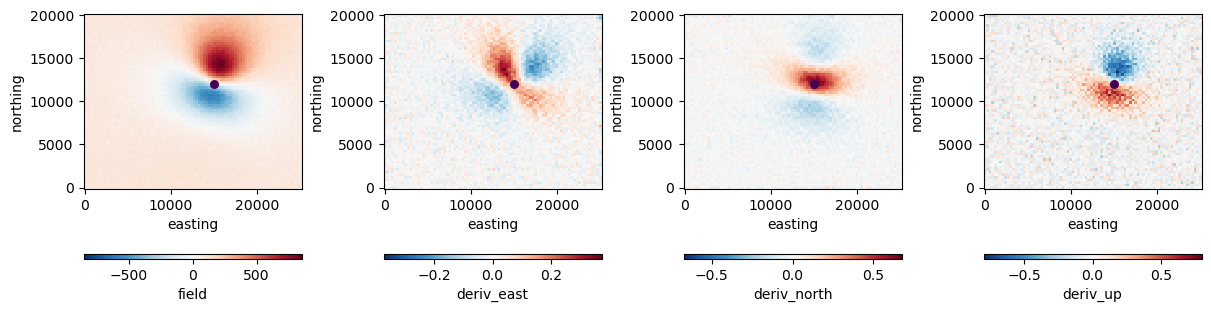

In [2]:
region = [0, 25e3, 0, 20e3]
height = 800
spacing = 300
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
intensity, inclination, declination = 5e11, -30, 15
true_coordinates = (15e3, 12e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(intensity, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Add noise and the base level
noise_level = 10  # nT
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
base_level = 100  # nT
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
pad_width = {
    "easting": data.easting.size // 2,
    "northing": data.northing.size // 2,
}
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
data["deriv_up"] = xrft.unpad(
    hm.derivative_upward(
        xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
    ),
    pad_width,
)

# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Inversion

Now run the Euler inversion with the same SI.

In [3]:
%%time
SI = 3
ei = euler.EulerInversion(structural_index=SI).fit_grid(data)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.location_}")
print(f"  STD       = {np.sqrt(np.diag(ei.covariance_))}")

Base level:
  True      = 100
  Estimated = 92.50001565308966
Position:
  True      = (15000.0, 12000.0, -3000.0)
  Estimated = [15045.17666968 12028.1140304  -2663.39315306]
  STD       = [157.12383423  97.75875017  69.07700716   3.65028605]
CPU times: user 441 ms, sys: 852 μs, total: 442 ms
Wall time: 58.9 ms


## Make a figure for the paper

Show the observed and predicted data, estimates from both methods, and progress per iteration of the Euler inversion. 

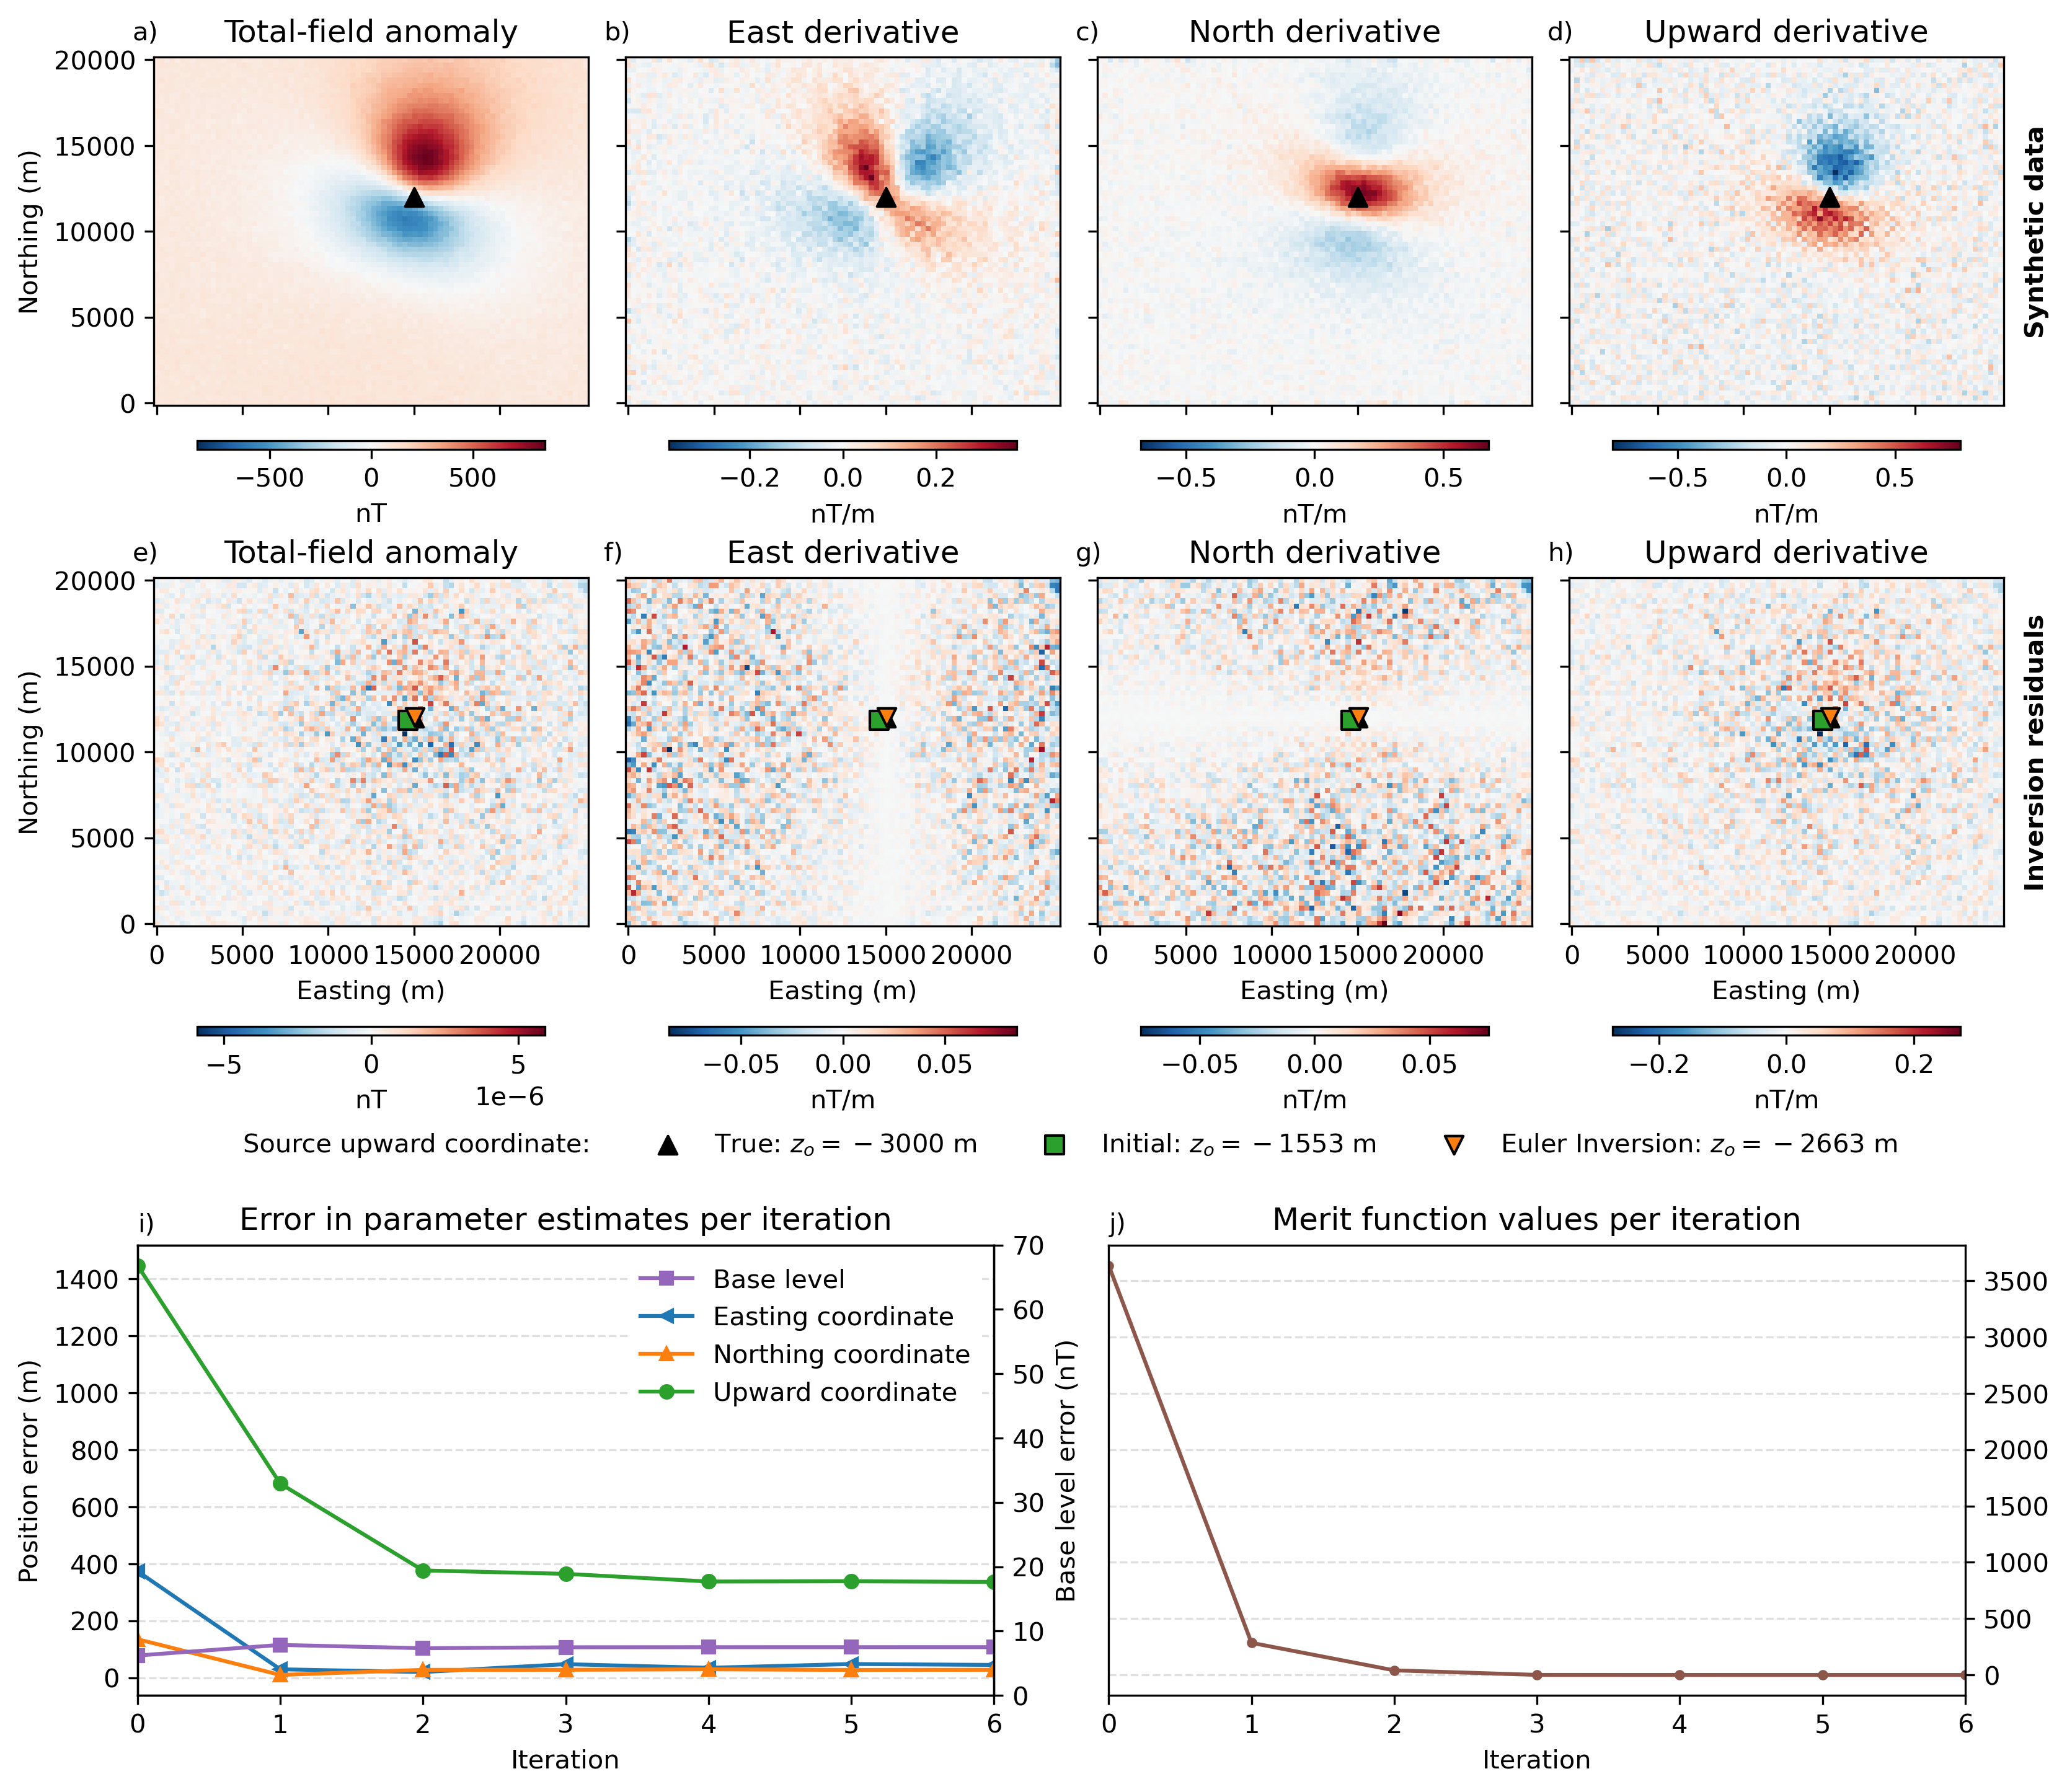

In [4]:
estimates = np.array(ei.location_per_iteration_)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(ei.base_level_per_iteration_)
base_error = np.abs(base_level - base_levels)

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig = plt.figure(figsize=(11, 9.5), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=[2, 1])

axes = figures[0].subplots(2, 4, sharey=True, sharex=True)

marker_size = 50
cbkwargs = dict(orientation="horizontal", aspect=40, shrink=0.8)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
data_names = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
for field, ax, label in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[0, :].ravel(), "abcd"
):
    ax.set_aspect("equal")
    tmp = data[field].plot.pcolormesh(ax=ax, add_labels=False, add_colorbar=False)
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    ax.set_title(data_names[field])
for field, ax in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[1, :].ravel()
):
    ax.set_aspect("equal")
    ax.set_title(data_names[field])
    tmp = (data[field] - ei.predicted_grid_[field]).plot.pcolormesh(
        ax=ax, add_labels=False, add_colorbar=False
    )
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    true = ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    initial = ax.scatter(
        *ei.location_per_iteration_[0][:2],
        c=colors[2],
        s=marker_size,
        marker="s",
        linewidths=1,
        edgecolors="black",
    )
    inv = ax.scatter(
        *ei.location_[:2],
        c=colors[1],
        s=marker_size,
        marker="v",
        linewidths=1,
        edgecolors="black",
    )
legend_title = plt.plot([], marker="", linestyle="")[0]
figures[0].legend(
    [legend_title, true, initial, inv],
    [
        "Source upward coordinate:",
        f"True: $z_o = {true_coordinates[-1]:.0f}$ m",
        f"Initial: $z_o = {ei.location_per_iteration_[0][-1]:.0f}$ m",
        f"Euler Inversion: $z_o = {ei.location_[-1]:.0f}$ m",
    ],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=4,
    loc="outside lower center",
)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 25e3, 5e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Synthetic data", fontweight="bold", labelpad=8)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Inversion residuals", fontweight="bold", labelpad=8)
for ax, label in zip(axes.ravel(), "abcdefgh"):
    ax.text(-0.05, 1.05, f"{label})", transform=ax.transAxes)

ax1, ax2 = figures[1].subplots(1, 2)

ax1.grid(axis="y", alpha=0.4, linestyle="--")
(east,) = ax1.plot(east_error, color=colors[0], marker="<", linestyle="-", markersize=5)
(north,) = ax1.plot(
    north_error, color=colors[1], marker="^", linestyle="-", markersize=5
)
(up,) = ax1.plot(up_error, color=colors[2], marker="o", linestyle="-", markersize=5)
twin = ax1.twinx()
(base,) = twin.plot(
    base_error, color=colors[4], marker="s", linestyle="-", markersize=5
)
ax1.legend(
    [base, east, north, up],
    ["Base level", "Easting coordinate", "Northing coordinate", "Upward coordinate"],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
twin.set_ylim(0, 70)
twin.set_ylabel("Base level error (nT)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in parameter estimates per iteration")
ax1.set_xlim(0, len(east_error) - 1)

ax2.grid(axis="y", alpha=0.4, linestyle="--")
ax2.plot(ei.merit_, label="Merit", color=colors[5], marker=".", linestyle="-")

ax2.set_xlabel("Iteration")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Merit function values per iteration")
ax2.set_xlim(0, len(east_error) - 1)

for ax, label in zip([ax1, ax2], "ij"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-proof-of-concept.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)

## Export a LaTeX file with information for the manuscript

Save things we want to include on the paper so that they can be referenced instead of copied.

In [5]:
output = rf"""
\newcommand{{\DefaultWeightsF}}{{{euler.DEFAULT_WEIGHTS[0]}}}
\newcommand{{\DefaultWeightsE}}{{{euler.DEFAULT_WEIGHTS[1]}}}
\newcommand{{\DefaultWeightsN}}{{{euler.DEFAULT_WEIGHTS[2]}}}
\newcommand{{\DefaultWeightsU}}{{{euler.DEFAULT_WEIGHTS[3]}}}
\newcommand{{\SynProofTrueEast}}{{\qty{{{true_coordinates[0]:.0f}}}{{\m}}}}
\newcommand{{\SynProofTrueNorth}}{{\qty{{{true_coordinates[1]:.0f}}}{{\m}}}}
\newcommand{{\SynProofTrueUp}}{{\qty{{{true_coordinates[2]:.0f}}}{{\m}}}}
\newcommand{{\SynProofTrueBase}}{{\qty{{{base_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynProofInt}}{{\qty{{{intensity:.0e}}}{{\ampere\per\meter}}}}
\newcommand{{\SynProofDec}}{{\qty{{{declination:.0f}}}{{\degree}}}}
\newcommand{{\SynProofInc}}{{\qty{{{inclination:.0f}}}{{\degree}}}}
\newcommand{{\SynProofNoise}}{{\qty{{{noise_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynProofHeight}}{{\qty{{{height:.0f}}}{{\m}}}}
\newcommand{{\SynProofSpacing}}{{\qty{{{spacing:.0f}}}{{\m}}}}
\newcommand{{\SynProofEstEast}}{{\qty{{{ei.location_[0]:.0f}}}{{\m}}}}
\newcommand{{\SynProofEstNorth}}{{\qty{{{ei.location_[1]:.0f}}}{{\m}}}}
\newcommand{{\SynProofEstUp}}{{\qty{{{ei.location_[2]:.0f}}}{{\m}}}}
\newcommand{{\SynProofEstBase}}{{\qty{{{ei.base_level_:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynProofNIter}}{{{ei.iterations_}}}
""".strip()
path = Path("..") / "paper" / "variables" / "synthetic-proof-of-concept.tex"
path.write_text(output)
print(output)

\newcommand{\DefaultWeightsF}{1}
\newcommand{\DefaultWeightsE}{0.1}
\newcommand{\DefaultWeightsN}{0.1}
\newcommand{\DefaultWeightsU}{0.025}
\newcommand{\SynProofTrueEast}{\qty{15000}{\m}}
\newcommand{\SynProofTrueNorth}{\qty{12000}{\m}}
\newcommand{\SynProofTrueUp}{\qty{-3000}{\m}}
\newcommand{\SynProofTrueBase}{\qty{100}{\nano\tesla}}
\newcommand{\SynProofInt}{\qty{5e+11}{\ampere\per\meter}}
\newcommand{\SynProofDec}{\qty{15}{\degree}}
\newcommand{\SynProofInc}{\qty{-30}{\degree}}
\newcommand{\SynProofNoise}{\qty{10}{\nano\tesla}}
\newcommand{\SynProofHeight}{\qty{800}{\m}}
\newcommand{\SynProofSpacing}{\qty{300}{\m}}
\newcommand{\SynProofEstEast}{\qty{15045}{\m}}
\newcommand{\SynProofEstNorth}{\qty{12028}{\m}}
\newcommand{\SynProofEstUp}{\qty{-2663}{\m}}
\newcommand{\SynProofEstBase}{\qty{93}{\nano\tesla}}
\newcommand{\SynProofNIter}{6}
